In [281]:
import os
import pandas as pd
from tqdm import tqdm
from re import sub
import numpy as np
import re
import sys
from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt

In [282]:
DATASETS_FOLDER = "datasets"    #the folder that contains the dataset directories to read in
FORMATTED_DATA_FILENAME = "true_data.json"  #the name of the file that contains the data to read in
DETECTION_RESULTS_FILENAME = "detection_results.json"
EVALUATION_RESULTS_FILENAME = "evaluation.txt"
DATASETS = ["MPC", "MSRP", "ETPC"]     #the folders in the DATASETS_FOLDER should be named like the datasets here
OUT_DIR = "output"      #the directory to output the formatted json in

FUZZY = "fuzzy_based_result"
SEMANTIC = "semantic_based_result"

FUZZY_BIN = "fuzzy_binary"
SEMANTIC_BIN = "semantic_binary"

FUZZY_THRESHHOLD = 0.65
SEMANTIC_THRESHHOLD = 0.75

pd.set_option("display.max_colwidth", None)

In [283]:
df = pd.read_json(os.path.join(OUT_DIR, DETECTION_RESULTS_FILENAME), orient = "index")
df.head()

,dataset,id_1,id_2,text_1,text_2,is_paraphrase,fuzzy_based_result,semantic_based_result
0,DMoP,HiDc8dkT,3n3Na3BD,Roy of the Rovers,Roy of the Rovers,True,1.00,1.000000
1,DMoP,5KfcxDBb,QUzQei9u,"Roy of the Rovers is a British comic strip about the life and times of a fictional footballer named Roy Race, who played for Melchester Rovers. The strip first appeared in the ""Tiger"" in 1954, before giving its name to a weekly (and later monthly) comic magazine, published by IPC and Fleetway from 1976 until 1995, in which it was the main feature.","Roy of the Rovers is a British funny cartoon about the life and times of an anecdotal footballer named Roy Race, who played for Melchester Rovers. The strip originally showed up in the ""Tiger"" in 1954, preceding giving its name to a week after week (and later month to month) comic magazine, distributed by IPC and Fleetway from 1976 until 1995, in which it was the principle include.",True,0.83,0.777395
2,DMoP,gxShcSRt,5nSAkBfd,"The weekly strip ran until 1993, following Roy's playing career until its conclusion after he lost his left foot in a helicopter crash. When the monthly comic was launched later that year the focus switched to Roy's son Rocky, who also played for Melchester. This publication was short-lived, and folded after only 19 issues. The adventures of the Race family were subsequently featured in the monthly ""Match of the Day"" football magazine, in which father and son were reunited as manager and player respectively. These strips began in 1997 and continued until the magazine's closure in May 2001.","The week after week strip kept running until 1993, after Roy's playing vocation until its decision after he lost his left foot in a helicopter crash. At the point when the month to month comic was propelled soon thereafter the center changed to Roy's child Rocky, who additionally played for Melchester. This production was brief, and collapsed after just 19 issues. The undertakings of the Race family were in this manner highlighted in the month to month ""Match of the Day"" football magazine, in which father and child were brought together as chief and player separately. These strips started in 1997 and proceeded until the magazine's conclusion in May 2001.",True,0.75,0.756583
3,DMoP,ERwDq4GC,mFG5GR3n,"Football-themed stories were a staple of British comics for boys from the 1950s onwards, and Roy of the Rovers was the most popular. To keep the strip exciting, Melchester was almost every year either competing for major honours or struggling against relegation to a lower division; a normal, uneventful season of mid-table mediocrity was unknown at Melchester Rovers. The strip followed the structure of the actual English football season, thus there were several months each year in summer when there was no league football. By far the most common summer storyline saw Melchester touring a fictional country in an exotic part of the world, often South America, where they would invariably be kidnapped and held to ransom. The average reader probably stayed with the comic regularly for only three or four years, therefore storylines were sometimes recycled; during the first ten years of his playing career, Roy was kidnapped at least four times. Roy also made numerous appearances for England, depicted playing alongside actual players such as Malcolm Macdonald and Trevor Francis.","Football-themed stories were a staple of British funnies for young men from the 1950s onwards, and Roy of the Rovers was the most prevalent. To keep the strip energizing, Melchester was pretty much consistently either seeking real distinctions or battling against transfer to a lower division; a typical, uneventful period of mid-table unremarkableness was obscure at Melchester Rovers. The strip pursued the structure of the real English football season, along these lines there were a while every year in summer when there was no association football. By a long shot the most well-known summer storyline saw Melchester

In [284]:
semantic_bin = []
fuzzy_bin = []
for i, row in df.iterrows():
    # semantic
    if row[SEMANTIC] >= SEMANTIC_THRESHHOLD:
        semantic_bin.append(True)
    else:
        semantic_bin.append(False)
    # fuzzy
    if row[FUZZY] >= FUZZY_THRESHHOLD:
        fuzzy_bin.append(True)
    else:
        fuzzy_bin.append(False)

df[SEMANTIC_BIN] = semantic_bin
df[FUZZY_BIN] = fuzzy_bin

In [285]:
precision_semantic, recall_semantic, thresholds_semantic = precision_recall_curve(df["is_paraphrase"], df[SEMANTIC])
precision_fuzzy, recall_fuzzy, thresholds_fuzzy = precision_recall_curve(df["is_paraphrase"], df[FUZZY])


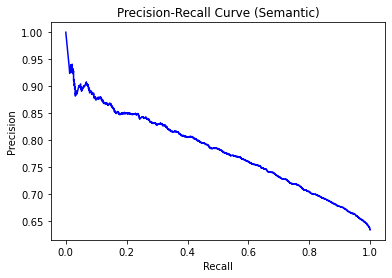

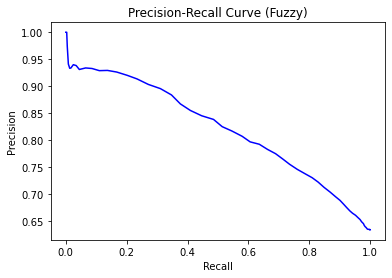

In [286]:
fig, ax = plt.subplots()
ax.plot(recall_semantic, precision_semantic, color='blue')
ax.set_title('Precision-Recall Curve (Semantic)')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.show()

fig, ax = plt.subplots()
ax.plot(recall_fuzzy, precision_fuzzy, color='blue')
ax.set_title('Precision-Recall Curve (Fuzzy)')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
plt.show()

In [295]:
# Confusion Matrix and f1 score for the defined threshhold
eval_string = ""
eval_string += "-------------------------" + "\n"
eval_string += "OVERALL DATA STATISTICS" + "\n"
eval_string += "-------------------------" + "\n"
eval_string += "Processed datasets: "
for d in DATASETS:
    eval_string += d + ", "
eval_string = eval_string[:-2] + "\n"

eval_string += "Number of sentence/paragraph pairs: " + str(len(df)) + "\n"
eval_string += "Amount of true paraphrases: " + str(len(df[df["is_paraphrase"] == True])) + "\n"
eval_string += "Amount of true non-paraphrases: " + str(len(df[df["is_paraphrase"] == False])) + "\n"

eval_string += "\nTHRESHHOLDS: " + "\n"
eval_string += "Semantic-Based: " + str(SEMANTIC_THRESHHOLD) + "\n"
eval_string += "Fuzzy-Based: " + str(FUZZY_THRESHHOLD) + "\n"

eval_string += "\n-------------------------" + "\n"
eval_string += "Confusion Matrix Semantic" + "\n"
eval_string += "------------------------- \n" + "\n"
actual = pd.Series(df["is_paraphrase"], name='Actual')
predicted = pd.Series(df[SEMANTIC_BIN], name='Predicted')
df_cross = pd.crosstab(actual, predicted)
eval_string += df_cross.to_string() + "\n"
f1 = f1_score(actual, predicted)
eval_string += "\nf1-score: " + str(f1) + "\n"
eval_string += "accuracy: " + str((df_cross[0][0]+df_cross[1][1]) / len(df)) + "\n"
eval_string += "precision: " + str(df_cross[1][1] / (df_cross[1][0]+df_cross[1][1])) + "\n"
eval_string += "recall: " + str(df_cross[1][1] / (df_cross[0][1]+df_cross[1][1])) + "\n"

eval_string += "\n-------------------------" + "\n"
eval_string += "Confusion Matrix Fuzzy" + "\n"
eval_string += "------------------------- \n" + "\n"
actual = pd.Series(df["is_paraphrase"], name='Actual')
predicted = pd.Series(df[FUZZY_BIN], name='Predicted')
df_cross = pd.crosstab(actual, predicted)
eval_string += df_cross.to_string() + "\n"
f1 = f1_score(actual, predicted)
eval_string += "\nf1-score: " + str(f1) + "\n"
eval_string += "accuracy: " + str((df_cross[0][0]+df_cross[1][1]) / len(df)) + "\n"
eval_string += "precision: " + str(df_cross[1][1] / (df_cross[1][0]+df_cross[1][1])) + "\n"
eval_string += "recall: " + str(df_cross[1][1] / (df_cross[0][1]+df_cross[1][1])) + "\n"

print(eval_string)

with open(os.path.join(OUT_DIR, EVALUATION_RESULTS_FILENAME), "w") as text_file:
    text_file.write(eval_string)

-------------------------
OVERALL DATA STATISTICS
-------------------------
Processed datasets: DMoP, MSRP, ETPC
Number of sentence/paragraph pairs: 11972
Amount of true paraphrases: 7597
Amount of true non-paraphrases: 4375

THRESHHOLDS: 
Semantic-Based: 0.75
Fuzzy-Based: 0.65

-------------------------
Confusion Matrix Semantic
------------------------- 

Predicted  False  True
Actual                
False       1366  3009
True         997  6600

f1-score: 0.7671742415436476
accuracy: 0.6653859004343468
precision: 0.6868560724320949
recall: 0.868763985783862

-------------------------
Confusion Matrix Fuzzy
------------------------- 

Predicted  False  True
Actual                
False       2113  2262
True        1449  6148

f1-score: 0.7681639282813769
accuracy: 0.6900267290344136
precision: 0.7310344827586207
recall: 0.8092668158483612



In [296]:
'''
Accuracy: May not be a good measure because the dataset is a little unbalanced (paraphrase & non-paraphrase)
Precision: Should ideally be high
Recall: Should ideally be high

'''

'\nAccuracy: May not be a good measure because the dataset is a little unbalanced (paraphrase & non-paraphrase)\nPrecision: Should ideally be high\nRecall: Should ideally be high\n\n'